# Milestone 4 : Analysis and Visualisation

In [1]:
from db_utils import RDSDatabaseConnector
from db_utils import load_dataframe
from EDA_classes import DataTransform
from EDA_classes import DataFrameInfo
from EDA_classes import Plotter
from EDA_classes import DataframeTransform

import seaborn as sns # type: ignore
import matplotlib.pyplot as plt
import pandas as pd

connect = RDSDatabaseConnector()
failure_df = load_dataframe()
transform_dataset = DataTransform(failure_df)
transform_dataset.auto_to_boolean()
transform_dataset.manual_to_categorical('Type')


transform = DataframeTransform(failure_df)
transform.impute_with_median('Tool wear [min]')
transform.impute_with_mean('Air temperature [K]')
transform.impute_with_mean('Process temperature [K]')
# transform.remove_rows_with_null()
transform.correct_skew_boxcox("Rotational speed [rpm]")
transform.remove_outliers_IQR('Rotational speed [rpm]', 1.5)
transform.remove_outliers_IQR('Torque [Nm]', 1.5)
failure_df.drop('Process temperature [K]', axis=1, inplace=True)

info = DataFrameInfo(failure_df)
plot = Plotter(failure_df)

### Task 1 : Current Operating Ranges
In this task if you're unsure what each column represents you may want to keep your data dictionary on hand as a reference. The business would like to understand at what ranges the machine is operating at currently. 

Create a table which displays to operating ranges of:
- Air Temperature
- Process temperature
- Rotational speed 
- Torque [Nm]
- Tool wear [min]

Then breakdown the same data to understand the ranges for each of the different product quality types.

The management would also like to know the upper limits of tool wear the machine tools have been operating at. Create a visualisation displaying the number of tools operating at different tool wear values.

     Air temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]
min                295.3                0.316215         13.9              0.0
max                304.5                0.316215         66.8            253.0
     Air temperature [K]        Rotational speed [rpm]           Torque [Nm]  \
                     min    max                    min       max         min   
Type                                                                           
H                  295.5  304.2               0.316215  0.316215        14.7   
L                  295.3  304.5               0.316215  0.316215        14.2   
M                  295.3  304.4               0.316215  0.316215        13.9   

           Tool wear [min]         
       max             min    max  
Type                               
H     65.3             0.0  246.0  
L     66.8             0.0  251.0  
M     65.9             0.0  253.0  


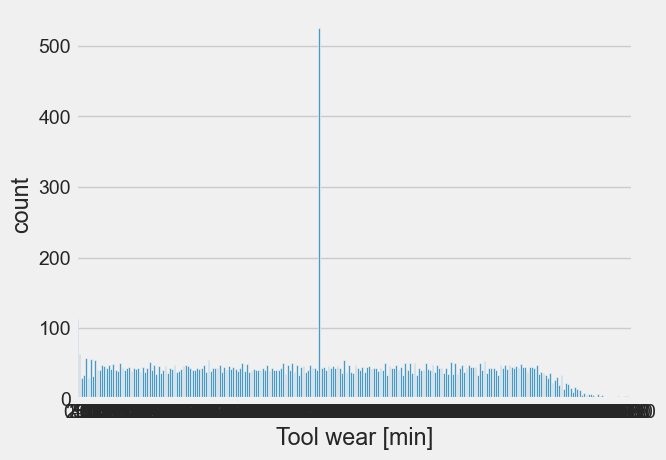

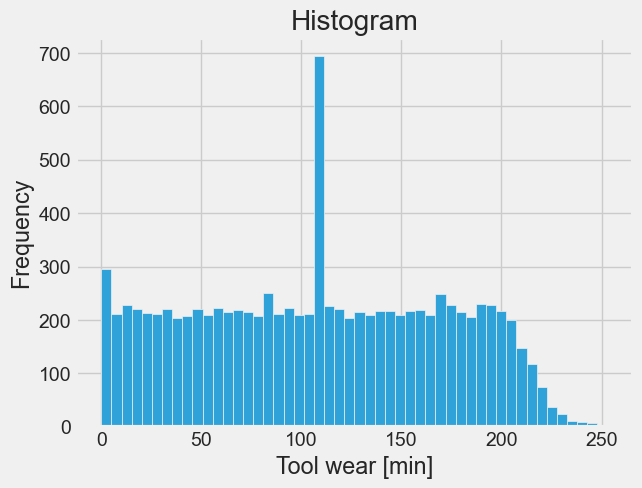

In [2]:
column_names = list(failure_df.columns)
numeric_features = [col for col in failure_df.columns[1:]
                    if failure_df[col].dtype == 'float64' or failure_df[col].dtype == 'int64']

operating_ranges_df = failure_df[numeric_features].agg(['min', 'max'])
print(operating_ranges_df.head(5))

operating_ranges_by_type = failure_df.groupby(['Type'], observed=False)[numeric_features].agg(['min', 'max'])
print(operating_ranges_by_type.head(10))

plot.countplot("Tool wear [min]")
plot.histogram("Tool wear [min]")

### Task 2 : Determine the failure rate in the process

You've been tasked with determining how many and the leading causes of failure are in the manufacturing process.

#### Step 1 : Determine and visualise how many failures have happened in the process

What percentage is this of the total? 
Check if the failures are being caused based on the quality of the product.


Machine failure
False    9608
True      268
Name: count, dtype: int64 



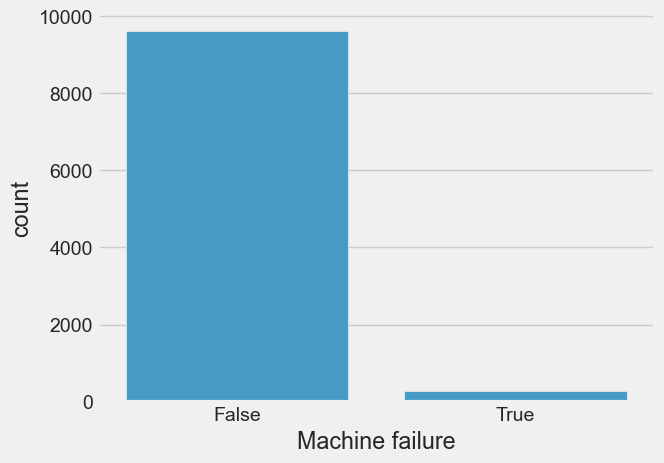

Machine failure
False    97.286351
True      2.713649
Name: proportion, dtype: float64 

Type  Machine failure
H     False               975
      True                 18
L     False              5739
      True                188
M     False              2894
      True                 62
Name: count, dtype: int64 

Type  Machine failure
H     False              98.187311
      True                1.812689
L     False              96.828075
      True                3.171925
M     False              97.902571
      True                2.097429
Name: proportion, dtype: float64 



In [3]:
print(f'\n{failure_df['Machine failure'].value_counts()} \n')
plot.countplot('Machine failure')
print(f'{failure_df['Machine failure'].value_counts(normalize=True) * 100} \n')

machine_failure_by_type = failure_df.groupby(['Type'], observed=False)['Machine failure'].value_counts()
print(f'{machine_failure_by_type} \n')

machine_failure_by_type_normalised = failure_df.groupby(['Type'], observed=False)['Machine failure'].value_counts(normalize=True) * 100
print(f'{machine_failure_by_type_normalised} \n')
# Machine failure twice as likely to occur on low quality product

#### Step 2 : What seems to be the leading causes of failure in the process? 

Create a visualisation of the number of failures due to each possible cause during the manufacturing process.

TWF     46
HDF    109
PWF     33
OSF     85
RNF      1
dtype: int64 



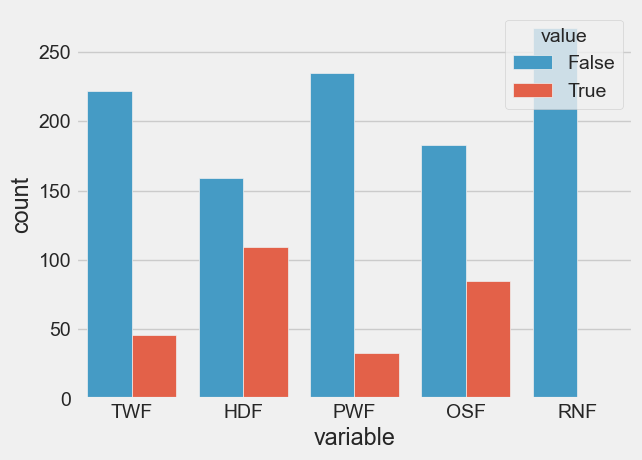

In [4]:
temp_df = failure_df.loc[failure_df['Machine failure'] == True]
temp_df.drop(temp_df.columns[[0,1,2,3,4,5,6,7]], axis=1, inplace=True)

temp_df_count = temp_df.sum()
print(f'{temp_df_count} \n')

df = pd.melt(temp_df)
sns.countplot(data=df, x='variable', hue='value')
plt.show()
# heat dissipation failure (HDF) is the leading cause of failures

### Task 3 : A deeper understanding of failures

With the failures identified you will need to dive deeper into what the possible causes of failure might be in the process.

For each different possible type of failure try to investigate if there is any correlation between any of the settings the machine was running at. Do the failures happen at certain torque ranges, processing temperatures or rpm?

Try to identify these risk factors so that the company can make more informed decisions about what settings to run the machines at. 

If you find any insight into when the machine is likely to fail then develop a strategy on how the machine might be setup to avoid this.


In [6]:
possible_failures = {'TWF':'Tool wear failure', 'HDF':'Heat dissipation failure', 'PWF':'Power failure', 'OSF':'Overstrain failure', 'RNF':'Random failure'}
for key, value in possible_failures.items():
    print('\n', value)
    operating_ranges_by_failure = failure_df.groupby([key], observed=False)[numeric_features].agg(['min', 'max', 'mean'])
    print(operating_ranges_by_failure)


 Tool wear failure
      Air temperature [K]                    Rotational speed [rpm]            \
                      min    max        mean                    min       max   
TWF                                                                             
False               295.3  304.5  300.005818               0.316215  0.316215   
True                296.9  304.4  300.267952               0.316215  0.316215   

                Torque [Nm]                  Tool wear [min]         \
           mean         min   max       mean             min    max   
TWF                                                                   
False  0.316215        13.9  66.8  39.920397             0.0  251.0   
True   0.316215        16.2  65.3  37.836957           108.0  253.0   

                   
             mean  
TWF                
False  107.781384  
True   211.282609  

 Heat dissipation failure
      Air temperature [K]                    Rotational speed [rpm]            \
          

TWF 
- Process temperature : range and mean are similar
- Rotational speed : range and mean are similar
- Torque : range and mean are similar
- Tool wear : When TWF = True, the mean is ~211 and minimum value is 108 compared to a mean of ~108 and minimum value of 0 when TWF=False
Summary : TWF is far more likely to occur when Tool wear is high

HDF
- Process temperature : When HDF = True, the mean is higher by ~1 degrees and the minimum value is ~ 4 degrees higher
- Rotational speed : When HDF = True, the mean and max are both significantly lower
- Torque : When HDF = True, the mean is higher by ~12 and the min is higher by ~21 
- Tool wear : range and mean are similar
Summary : HDF is not likely to occur when Process temperature and Torque are kept lower and rotational speed is higher

PWF - 
- Process temperature : the means are very similar, although the minimum value is higher by ~3 when PWF = True
- Rotational speed : When PWF = True, the mean and max are both significantly lower
- Torque : When PWF = True, the mean is higher by ~22 and the min is higher by ~38 
- Tool wear : range and mean are similar
Summary : PWF more likely to occur when Torque is high and rotational speed is low

OSF - 
- Process temperature : range and mean are very similar
- Rotational speed : When OSF = True, the mean and max are both lower
- Torque : When OSF = True, the mean is higher by ~16 and the min is higher by ~26 
- Tool wear : When OSF = True, the mean is ~205 and minimum value is 108 compared to a mean of ~107 and minimum value of 0 when OSF = False

RNF - 
- Process temperature : range and mean are very similar
- Rotational speed : range and mean are similar
- Torque : range and mean are similar
- Tool wear : range and mean are similar
Summary : Nothing much of note

Risk Factors are:
- High Torque : exceeding 40 Nm
- High Tool wear : exceeding 108 min
- Low Rotational speed : below 1500 rpm
